In [3]:
import numpy as np
from scipy.linalg import sqrtm 
from scipy.special import softmax
import networkx as nx
from networkx.algorithms.community.modularity_max import greedy_modularity_communities
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from IPython.display import HTML
import pandas as pd
import pickle
import networkx as nx
import pickle
import os

In [2]:
def draw_kkl(nx_G, label_map, node_color, pos=None, **kwargs):
    fig, ax = plt.subplots(figsize=(10,10))
    if pos is None:
        pos = nx.spring_layout(nx_G, k=5/np.sqrt(nx_G.number_of_nodes()))

    nx.draw(
        nx_G, pos, with_labels=label_map is not None, 
        labels=label_map, 
        node_color=node_color, 
        ax=ax, **kwargs)

In [4]:
autCOCI = pd.read_pickle("autCOCI.pkl")

In [5]:
Fmat_Publication = autCOCI.drop(['Venue_citing','Venue_cited','autID_citing','autID_cited'], axis=1) 

In [7]:
g= nx.from_pandas_edgelist(Fmat_Publication, 'citing','cited')

In [8]:
g.number_of_nodes(), g.number_of_edges()

(6155, 14917)

In [9]:
communities = greedy_modularity_communities(g)

[frozenset({'10.1007/s11192-013-1164-8',
            '10.1109/asonam.2010.12',
            '10.1016/j.ijpe.2011.11.027',
            '10.1080/09737766.2011.10700899',
            '10.1007/978-3-319-49586-6_40',
            '10.1007/s00038-014-0615-1',
            '10.1016/j.acalib.2015.10.005',
            '10.1016/j.joi.2011.06.006',
            '10.1108/00907321211228237',
            '10.1109/fskd.2015.7382045',
            '10.1371/journal.pone.0019917',
            '10.1108/jd-06-2012-0078',
            '10.1002/isaf.1376',
            '10.3989/redc.2014.3.1119',
            '10.3389/fpsyg.2014.00559',
            '10.1371/journal.pone.0106474',
            '10.1186/s12302-015-0062-5',
            '10.1108/ajim-11-2013-0127',
            '10.1002/ejoc.200801243',
            '10.1177/0004867413486555',
            '10.1007/978-3-319-03437-9_25',
            '10.1111/cobi.12226',
            '10.1111/1750-3841.13108',
            '10.1093/bjsw/bct183',
            '10.13060/0038028

In [10]:
colors = np.zeros(g.number_of_nodes())
for i, com in enumerate(communities):
    colors[list(com)] = i

n_classes = np.unique(colors).shape[0]
labels = np.eye(n_classes)[colors.astype(int)]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

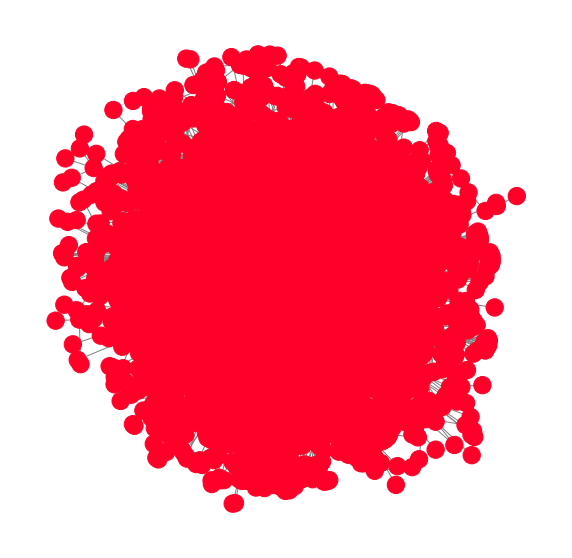

In [11]:
_ = draw_kkl(g, None, colors, cmap='gist_rainbow', edge_color='gray')

In [13]:
A = nx.to_numpy_matrix(g)
A

matrix([[0., 1., 0., ..., 0., 0., 0.],
        [1., 0., 1., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
A_mod = A + np.eye(g.number_of_nodes()) # add self-connections

D_mod = np.zeros_like(A_mod)
np.fill_diagonal(D_mod, np.asarray(A_mod.sum(axis=1)).flatten())


D_mod_invroot = np.linalg.inv(sqrtm(D_mod))

A_hat = D_mod_invroot @ A_mod @ D_mod_invroot

In [15]:
X = np.eye(g.number_of_nodes())

In [17]:
def glorot_init(nin, nout):
    sd = np.sqrt(6.0 / (nin + nout))
    return np.random.uniform(-sd, sd, size=(nin, nout))


def xent(pred, labels):
    return -np.log(pred)[np.arange(pred.shape[0]), np.argmax(labels, axis=1)]


def norm_diff(dW, dW_approx):
    return np.linalg.norm(dW - dW_approx) / (np.linalg.norm(dW) + np.linalg.norm(dW_approx))


class GradDescentOptim():
    def __init__(self, lr, wd):
        self.lr = lr
        self.wd = wd
        self._y_pred = None
        self._y_true = None
        self._out = None
        self.bs = None
        self.train_nodes = None
        
    def __call__(self, y_pred, y_true, train_nodes=None):
        self.y_pred = y_pred
        self.y_true = y_true
        
        if train_nodes is None:
            self.train_nodes = np.arange(y_pred.shape[0])
        else:
            self.train_nodes = train_nodes
            
        self.bs = self.train_nodes.shape[0]
        
    @property
    def out(self):
        return self._out
    
    @out.setter
    def out(self, y):
        self._out = y
    

class GCNLayer():
    def __init__(self, n_inputs, n_outputs, activation=None, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.activation = activation
        self.name = name
        
    def __repr__(self):
        return f"GCN: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
        
    def forward(self, A, X, W=None):
        """
        Assumes A is (bs, bs) adjacency matrix and X is (bs, D), 
            where bs = "batch size" and D = input feature length
        """
        self._A = A
        self._X = (A @ X).T # for calculating gradients.  (D, bs)
        
        if W is None:
            W = self.W
        
        H = W @ self._X # (h, D)*(D, bs) -> (h, bs)
        if self.activation is not None:
            H = self.activation(H)
        self._H = H # (h, bs)
        return self._H.T # (bs, h)
    
    def backward(self, optim, update=True):
        dtanh = 1 - np.asarray(self._H.T)**2 # (bs, out_dim)
        d2 = np.multiply(optim.out, dtanh)  # (bs, out_dim) *element_wise* (bs, out_dim)
        
        self.grad = self._A @ d2 @ self.W # (bs, bs)*(bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)     
        optim.out = self.grad
        
        dW = np.asarray(d2.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, D) -> (out_dim, D)
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:
            self.W -= (dW + dW_wd) * optim.lr 
        
        return dW + dW_wd

    
class SoftmaxLayer():
    def __init__(self, n_inputs, n_outputs, name=''):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.W = glorot_init(self.n_outputs, self.n_inputs)
        self.b = np.zeros((self.n_outputs, 1))
        self.name = name
        self._X = None # Used to calculate gradients
        
    def __repr__(self):
        return f"Softmax: W{'_'+self.name if self.name else ''} ({self.n_inputs}, {self.n_outputs})"
    
    def shift(self, proj):
        shiftx = proj - np.max(proj, axis=0, keepdims=True)
        exps = np.exp(shiftx)
        return exps / np.sum(exps, axis=0, keepdims=True)
        
    def forward(self, X, W=None, b=None):
        """Compute the softmax of vector x in a numerically stable way.
        
        X is assumed to be (bs, h)
        """
        self._X = X.T
        if W is None:
            W = self.W
        if b is None:
            b = self.b

        proj = np.asarray(W @ self._X) + b # (out, h)*(h, bs) = (out, bs)
        return self.shift(proj).T # (bs, out)
    
    def backward(self, optim, update=True):
        # should take in optimizer, update its own parameters and update the optimizer's "out"
        # Build mask on loss
        train_mask = np.zeros(optim.y_pred.shape[0])
        train_mask[optim.train_nodes] = 1
        train_mask = train_mask.reshape((-1, 1))
        
        # derivative of loss w.r.t. activation (pre-softmax)
        d1 = np.asarray((optim.y_pred - optim.y_true)) # (bs, out_dim)
        d1 = np.multiply(d1, train_mask) # (bs, out_dim) with loss of non-train nodes set to zero
        
        self.grad = d1 @ self.W # (bs, out_dim)*(out_dim, in_dim) = (bs, in_dim)
        optim.out = self.grad
        
        dW = (d1.T @ self._X.T) / optim.bs  # (out_dim, bs)*(bs, in_dim) -> (out_dim, in_dim)
        db = d1.T.sum(axis=1, keepdims=True) / optim.bs # (out_dim, 1)
                
        dW_wd = self.W * optim.wd / optim.bs # weight decay update
        
        if update:   
            self.W -= (dW + dW_wd) * optim.lr
            self.b -= db.reshape(self.b.shape) * optim.lr
        
        return dW + dW_wd, db.reshape(self.b.shape)

In [18]:
gcn1 = GCNLayer(g.number_of_nodes(), 2, activation=np.tanh, name='1')
sm1 = SoftmaxLayer(2, n_classes, "SM")
opt = GradDescentOptim(lr=0, wd=1.)

NameError: name 'n_classes' is not defined

In [ ]:
gcn1_out = gcn1.forward(A_hat, X)
opt(sm1.forward(gcn1_out), labels)